In [1]:
from google.cloud import storage
from google.oauth2 import service_account

import os
from pathlib import Path

from colearn_examples.config import ColearnConfig, TrainingData, ModelConfig
from colearn_examples.covid_xray import prepare_single_client, CovidXrayConfig

import matplotlib.pyplot as plt

In [2]:
def download_data_from_gcloud(cloud_data_dir, local_data_dir, credentials=None):
    bucket_name = cloud_data_dir.replace('gs://', '')
    bucket_name, prefix = bucket_name.split('/', 1)
    print(bucket_name, prefix)

    storage_client = storage.Client(credentials=credentials)
    bucket = storage_client.bucket(bucket_name=bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)  # Get list of files

    local_full_path = Path(local_data_dir) / prefix
    os.makedirs(local_full_path, exist_ok=True)
    file_counter = 0
    for blob in blobs:
        filename = blob.name
        print(filename)
        blob.download_to_filename(Path(local_data_dir) / filename)  # Download
        file_counter += 1

    if file_counter == 0:
        raise Exception("No data in folder: " + cloud_data_dir)

    return local_full_path


def get_data(data_dir, credentials=None):
    if str(data_dir).startswith("gs://"):
        return download_data_from_gcloud(data_dir, '/tmp/data_download', credentials=credentials)
    return data_dir

def model_factory(n_learners,data_root, i):
    print("CREATE LEARNER: ",i)
    colearn_config = ColearnConfig(task=TrainingData["COVID"],n_learners=n_learners, seed=10)
    learner_config = CovidXrayConfig(colearn_config.shuffle_seed)

    credentials_path = "/Users/qati/code/infra-mlfabric/config/fetch-ai-sandbox-mlfabric.json"
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=credentials_path
    credentials = service_account.Credentials.from_service_account_file(
        credentials_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
    )
    
    data_dir="{}{}".format(data_root, i)

    local_data_dir = get_data(data_dir, credentials=credentials)
    print("GCLOUD data downloaded to ", local_data_dir)
    
    learner_data = prepare_single_client(learner_config, local_data_dir)

    return learner_config.model_type(config=learner_config, data=learner_data)

def train_nodes(learners):
    val_acc = []
    test_acc =[]
    train_acc =[]
    for l in learners:
        tra = l._train_model()
        w = l.get_weights()
        pw = l.test_model(w)
        train_acc.append(tra)
        test_acc.append(pw.test_accuracy)
        val_acc.append(pw.vote_accuracy)
    return train_acc, val_acc, test_acc

In [3]:
data_root = "gs://mlfabric/var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_"
n_learners=6

learners = []
for i in range(n_learners):
    learners.append(model_factory(n_learners, data_root, i))

CREATE LEARNER:  0
mlfabric var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_0
var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_0/images.pickle
var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_0/labels.pickle
GCLOUD data downloaded to  /tmp/data_download/var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_0


Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 10,435
Trainable params: 10,435
Non-trainable params: 0
_________________________________________________________

Validating: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/qati/code/colearn/colearn_examples/keras_learner.py:128: RuntimeWarning: invalid value encountered in true_divide
  np.diag(conf_matrix) / conf_matrix.sum(axis=1), nan=1.0


Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [8 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.19      1.00      0.32         3
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.19      0.19      0.19        16
   macro avg       0.02      0.10      0.

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_1/labels.pickle
GCLOUD data downloaded to  /tmp/data_download/var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_1
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (

Validating: 100%|██████████| 2/2 [00:00<00:00, 16.14it/s]


Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [8 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.19      1.00      0.32         3
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.19      0.19      0.19        16
   macro avg       0.02      0.10      0.

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_2/labels.pickle
GCLOUD data downloaded to  /tmp/data_download/var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_2
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (

Validating: 100%|██████████| 2/2 [00:00<00:00, 23.01it/s]


Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[ 0  4  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.12      1.00      0.22         2
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00       

Validating: 100%|██████████| 2/2 [00:00<00:00, 23.71it/s]

var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_3/labels.pickle
GCLOUD data downloaded to  /tmp/data_download/var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_3
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 

CREATE LEARNER:  4
mlfabric var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_4
var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_4/images.pickle


Validating: 100%|██████████| 2/2 [00:00<00:00, 28.24it/s]

var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_4/labels.pickle
GCLOUD data downloaded to  /tmp/data_download/var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_4
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 

var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_5/images.pickle
var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_5/labels.pickle
GCLOUD data downloaded to  /tmp/data_download/var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_5
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         


Validating: 100%|██████████| 2/2 [00:00<00:00, 24.09it/s]

COVID train generator, input shape  55 x (64,) ; label:  ()
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 6 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         6
           2       0.25      1.00      0.40         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.25      0.25  

In [4]:
epochs = 300

train_acc = {}
val_acc = {}
test_acc = {}

for i in range(n_learners):
    train_acc[i] = []
    val_acc[i] = []
    test_acc[i] = []

for e in range(epochs):
    print("Epoch: ", e)
    tra, v, tsa = train_nodes(learners)
    for i in range(n_learners):
        train_acc[i].append(tra[i])
        val_acc[i].append(v[i])
        test_acc[i].append(tsa[i])

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch:  0
COVID train generator, input shape  56 x (64,) ; label:  ()


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 6 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         4
           2       0.38      1.00      0.55         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [8 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.38      1.00      0.55         6
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 1 2 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         9
           2       0.27      1.00      0.42         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.25      0.25      0.25        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 9 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.25      1.00      0.40         4
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.25      0.25      0.25        16
   macro avg      

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 8 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.31      1.00      0.48         5
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.04it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 5 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         6
           2       0.31      1.00      0.48         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.968750:  57%|█████▋    | 4/7 [00:00<00:00, 39.06it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        10
           2       0.19      1.00      0.32         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 39.22it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 36.19it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 4 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         7
           2       0.31      1.00      0.48         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 39.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 7 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.38      1.00      0.55         6
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.000000:  67%|██████▋   | 4/6 [00:00<00:00, 38.87it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 5 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.38      1.00      0.55         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Validating: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]

Getting vote accuracy:



Accuracy 0.083333:  29%|██▊       | 2/7 [00:00<00:00, 19.22it/s]

Test balanced_accuracy_score: 0.7333333333333333
Confusion martrix:
 [[0 1 5 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         7
           2       0.08      0.33      0.12         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.06      0.06      0.06        16
   macro avg       0.01   

Accuracy 1.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 6 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         3
           2       0.44      1.00      0.61         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 34.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 2 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.44      1.00      0.61         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.19      1.00      0.32         3
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.19      0.19      0.19        16
   macro avg      

Accuracy 0.031250:  67%|██████▋   | 4/6 [00:00<00:00, 38.68it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8666666666666666
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [2 4 0 0 0 0 0 0 0 0]
 [3 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.67      0.67      0.67         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 3 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.44      1.00      0.61         7
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.875000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 4 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         6
           2       0.38      1.00      0.55         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 38.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [7 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.562500:  57%|█████▋    | 4/7 [00:00<00:00, 39.21it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 4 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.50      1.00      0.67         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 38.04it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 7 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.38      1.00      0.55         6
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 36.73it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 6 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.44      1.00      0.61         7
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.656250:  57%|█████▋    | 4/7 [00:00<00:00, 39.27it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 3 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         6
           2       0.44      1.00      0.61         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 37.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.21it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 4 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.50      1.00      0.67         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.625000:  57%|█████▋    | 4/7 [00:00<00:00, 34.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.875
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [1 3 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       0.60      0.75      0.67         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg    

Accuracy 0.031250:  67%|██████▋   | 4/6 [00:00<00:00, 34.48it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 35.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 5 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.19      1.00      0.32         3
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.19      0.19      0.19        16
   macro avg      

Accuracy 0.718750:  57%|█████▋    | 4/7 [00:00<00:00, 38.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 7 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         6
           2       0.19      1.00      0.32         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.19      0.19      0.19        16
   macro avg      

Accuracy 0.000000:  43%|████▎     | 3/7 [00:00<00:00, 27.52it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8577777777777778
Confusion martrix:
 [[4 0 1 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [2 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.00      0.00      0.00         2
           2       0.88      0.78      0.82         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 3 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         7
           2       0.38      1.00      0.55         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [9 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.31      1.00      0.48         5
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.25      1.00      0.40         4
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.25      0.25      0.25        16
   macro avg      

Accuracy 0.062500:  57%|█████▋    | 4/7 [00:00<00:00, 34.98it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 5 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.50      1.00      0.67         8
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.656250:  57%|█████▋    | 4/7 [00:00<00:00, 35.52it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 2 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.44      1.00      0.61         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8318181818181818
Confusion martrix:
 [[9 0 2 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.00      0.00      0.00         3
           2       0.33      0.50      0.40         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.541667:  43%|████▎     | 3/7 [00:00<00:00, 27.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[ 0  0  2  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.69      1.00      0.81        11
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.625000:  57%|█████▋    | 4/7 [00:00<00:00, 35.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [8 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.31      1.00      0.48         5
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.093750:  67%|██████▋   | 4/6 [00:00<00:00, 36.13it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.56      1.00      0.72         9
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 33.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 6 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      1.00      0.67         8
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 7 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         2
           2       0.44      1.00      0.61         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8428571428571429
Confusion martrix:
 [[3 0 4 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.00      0.00      0.00         2
           2       0.64      1.00      0.78         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.843750:  57%|█████▋    | 4/7 [00:00<00:00, 34.02it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 4 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         7
           2       0.31      1.00      0.48         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 36.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.093750:  67%|██████▋   | 4/6 [00:00<00:00, 36.82it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.041667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.44      1.00      0.61         7
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 37.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 5 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         7
           2       0.25      1.00      0.40         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.25      0.25      0.25        16
   macro avg      

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 38.26it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.85
Confusion martrix:
 [[ 1  0  1  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.20      0.50      0.29         2
           1       0.00      0.00      0.00         4
           2       0.91      1.00      0.95        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00   

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 36.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 4 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         7
           2       0.31      1.00      0.48         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.750000:  57%|█████▋    | 4/7 [00:00<00:00, 38.86it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [9 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.38      1.00      0.55         6
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.062500:  67%|██████▋   | 4/6 [00:00<00:00, 37.27it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[ 2  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.12      1.00      0.22         2
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.062500:  57%|█████▋    | 4/7 [00:00<00:00, 38.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.38      1.00      0.55         6
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.06it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 5 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         6
           2       0.31      1.00      0.48         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8857142857142858
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [1 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57         4
           1       0.00      0.00      0.00         5
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.687500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 2 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         5
           2       0.56      1.00      0.72         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   macro avg      

Accuracy 0.750000:  57%|█████▋    | 4/7 [00:00<00:00, 38.31it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 38.96it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 37.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 3 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.44      1.00      0.61         7
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 39.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.869047619047619
Confusion martrix:
 [[0 0 3 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.83      0.83      0.83         6
           2       0.60      0.86      0.71         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   m

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8666666666666666
Confusion martrix:
 [[4 0 2 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.00      0.00      0.00         4
           2       0.75      1.00      0.86         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 6 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         1
           2       0.56      1.00      0.72         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.156250:  67%|██████▋   | 4/6 [00:00<00:00, 38.05it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Validating: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.38      1.00      0.55         6
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.125000:  71%|███████▏  | 5/7 [00:00<00:00, 40.49it/s]

Getting test accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 5 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.12      1.00      0.22         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.12      0.12      0.12         8
   macro avg      

Accuracy 0.458333:  43%|████▎     | 3/7 [00:00<00:00, 26.73it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.875
Confusion martrix:
 [[0 0 4 0 0 0 0 0 0 0]
 [0 6 2 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      0.75      0.86         8
           2       0.40      1.00      0.57         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   macro avg    

Accuracy 0.041667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8777777777777779
Confusion martrix:
 [[7 0 2 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.00      0.00      0.00         1
           2       0.75      1.00      0.86         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.843750:  57%|█████▋    | 4/7 [00:00<00:00, 35.68it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 2 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         8
           2       0.38      1.00      0.55         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.94it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [7 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.31      1.00      0.48         5
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Testing: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.38      1.00      0.55         6
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.062500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 7 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.31      1.00      0.48         5
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.875
Confusion martrix:
 [[0 1 5 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      0.75      0.75         4
           2       0.50      1.00      0.67         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   macro avg    

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 36.80it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8800000000000001
Confusion martrix:
 [[4 0 1 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      0.80      0.57         5
           1       0.00      0.00      0.00         5
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.875000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 4 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         9
           2       0.19      1.00      0.32         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.19      0.19      0.19        16
   macro avg      

Accuracy 0.593750:  57%|█████▋    | 4/7 [00:00<00:00, 35.90it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [9 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.31      1.00      0.48         5
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.093750:  67%|██████▋   | 4/6 [00:00<00:00, 34.90it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [7 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.19      1.00      0.32         3
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.19      0.19      0.19        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      1.00      0.67         8
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.583333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8857142857142858
Confusion martrix:
 [[0 0 5 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.80      1.00      0.89         4
           2       0.55      0.86      0.67         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8857142857142858
Confusion martrix:
 [[6 0 1 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.00      0.00      0.00         2
           2       0.88      1.00      0.93         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.916667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         6
           2       0.56      1.00      0.72         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   macro avg      

Accuracy 0.562500:  57%|█████▋    | 4/7 [00:00<00:00, 34.83it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.156250:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.82
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [4 1 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.70         8
           1       1.00      0.20      0.33         5
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   macro avg     

Accuracy 0.041667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      1.00      0.67         8
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.583333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8657142857142857
Confusion martrix:
 [[0 1 3 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.75      0.86      0.80         7
           2       0.50      0.80      0.62         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8714285714285716
Confusion martrix:
 [[6 0 1 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [1 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.00      0.00      0.00         2
           2       0.86      0.86      0.86         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.875000:  43%|████▎     | 3/7 [00:00<00:00, 27.80it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 4 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         7
           2       0.31      1.00      0.48         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.38      1.00      0.55         6
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 3 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.38      1.00      0.55         6
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 34.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8966666666666667
Confusion martrix:
 [[1 3 2 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.56      1.00      0.71         5
           2       0.67      0.80      0.73         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 35.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.875
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [7 0 0 0 0 0 0 0 0 0]
 [1 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.38      1.00      0.56         5
           1       0.00      0.00      0.00         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg    

Accuracy 0.875000:  57%|█████▋    | 4/7 [00:00<00:00, 34.71it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 1 3 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         5
           2       0.47      1.00      0.64         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.625000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [9 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.25      1.00      0.40         4
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.25      0.25      0.25        16
   macro avg      

Accuracy 0.125000:  67%|██████▋   | 4/6 [00:00<00:00, 35.24it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.31      1.00      0.48         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 9 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.19      1.00      0.32         3
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.19      0.19      0.19        16
   macro avg      

Accuracy 0.593750:  57%|█████▋    | 4/7 [00:00<00:00, 37.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[0 0 4 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      1.00      1.00         6
           2       0.60      1.00      0.75         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg      

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 37.26it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg      

Accuracy 0.812500:  57%|█████▋    | 4/7 [00:00<00:00, 36.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 0 5 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         6
           2       0.31      1.00      0.48         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.781250:  57%|█████▋    | 4/7 [00:00<00:00, 39.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.38      1.00      0.55         6
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.25      1.00      0.40         4
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.25      0.25      0.25        16
   macro avg      

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 35.53it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      1.00      0.67         8
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 37.14it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8833333333333334
Confusion martrix:
 [[0 3 3 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      1.00      0.67         4
           2       0.62      0.83      0.71         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 38.27it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.00      0.00      0.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg      

Accuracy 0.843750:  57%|█████▋    | 4/7 [00:00<00:00, 39.10it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 1 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         6
           2       0.53      1.00      0.70         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.43it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.156250:  67%|██████▋   | 4/6 [00:00<00:00, 38.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [7 0 0 0 0 0 0 0 0 0]
 [2 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57         6
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.062500:  57%|█████▋    | 4/7 [00:00<00:00, 37.06it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 6 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.44      1.00      0.61         7
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.593750:  57%|█████▋    | 4/7 [00:00<00:00, 38.23it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[3 0 1 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         6
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 39.67it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.888888888888889
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [1 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.00      0.00      0.00         2
           2       1.00      0.89      0.94         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   m

Accuracy 0.843750:  57%|█████▋    | 4/7 [00:00<00:00, 38.43it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.825
Confusion martrix:
 [[0 3 4 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.25      0.25      0.25         4
           2       0.42      1.00      0.59         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg    

Accuracy 0.562500:  57%|█████▋    | 4/7 [00:00<00:00, 38.87it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.062500:  67%|██████▋   | 4/6 [00:00<00:00, 39.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 38.05it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 6 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.38      1.00      0.55         6
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.656250:  57%|█████▋    | 4/7 [00:00<00:00, 39.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9266666666666665
Confusion martrix:
 [[2 0 1 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.80      1.00      0.89         8
           2       0.75      0.60      0.67         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 39.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       0.00      0.00      0.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg      

Accuracy 0.812500:  57%|█████▋    | 4/7 [00:00<00:00, 39.21it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8333333333333334
Confusion martrix:
 [[0 0 1 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.33      0.50         6
           2       0.64      1.00      0.78         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.69it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61         7
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.062500:  67%|██████▋   | 4/6 [00:00<00:00, 38.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8333333333333333
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [4 2 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.43      1.00      0.60         6
           1       1.00      0.33      0.50         6
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 39.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 5 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.31      1.00      0.48         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.593750:  57%|█████▋    | 4/7 [00:00<00:00, 38.84it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8875
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [1 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.00      0.00      0.00         2
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg   

Accuracy 0.812500:  57%|█████▋    | 4/7 [00:00<00:00, 38.48it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[ 0  3  1  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         2
           2       0.77      1.00      0.87        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.718750:  57%|█████▋    | 4/7 [00:00<00:00, 37.23it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.125000:  67%|██████▋   | 4/6 [00:00<00:00, 37.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8833333333333334
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [1 5 0 0 0 0 0 0 0 0]
 [3 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       0.83      0.83      0.83         6
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      1.00      0.67         8
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.656250:  57%|█████▋    | 4/7 [00:00<00:00, 39.58it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[4 0 1 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         6
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 37.86it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8666666666666666
Confusion martrix:
 [[4 0 2 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.00      0.00      0.00         4
           2       0.75      1.00      0.86         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.812500:  57%|█████▋    | 4/7 [00:00<00:00, 39.71it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.86
Confusion martrix:
 [[0 1 3 0 0 0 0 0 0 0]
 [0 3 2 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.75      0.60      0.67         5
           2       0.58      1.00      0.74         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   macro avg     

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 36.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [7 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.31      1.00      0.48         5
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31        16
   macro avg      

Accuracy 0.125000:  67%|██████▋   | 4/6 [00:00<00:00, 36.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8333333333333333
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [2 1 0 0 0 0 0 0 0 0]
 [3 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       0.33      0.33      0.33         3
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.38      1.00      0.55         6
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 38.49it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9433333333333334
Confusion martrix:
 [[4 1 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.71      0.83      0.77         6
           2       0.80      0.80      0.80         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 37.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       0.00      0.00      0.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg      

Accuracy 0.843750:  57%|█████▋    | 4/7 [00:00<00:00, 36.54it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9111111111111111
Confusion martrix:
 [[0 0 0 0 0 0 0 0 0 0]
 [0 1 8 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.11      0.20         9
           2       0.47      1.00      0.64         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   

Accuracy 0.500000:  43%|████▎     | 3/7 [00:00<00:00, 28.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.166667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8875
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [1 7 0 0 0 0 0 0 0 0]
 [2 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.88      0.88      0.88         8
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg   

Accuracy 0.333333:  43%|████▎     | 3/7 [00:00<00:00, 29.19it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 5 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.38      1.00      0.55         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.625000:  57%|█████▋    | 4/7 [00:00<00:00, 37.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[2 0 1 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.88      1.00      0.93         7
           2       0.83      0.83      0.83         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 34.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg      

Accuracy 0.750000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.82
Confusion martrix:
 [[0 5 1 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.17      0.20      0.18         5
           2       0.50      1.00      0.67         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg     

Accuracy 0.593750:  57%|█████▋    | 4/7 [00:00<00:00, 35.55it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8400000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [3 2 0 0 0 0 0 0 0 0]
 [4 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.46      1.00      0.63         6
           1       0.67      0.40      0.50         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   

Accuracy 0.093750:  67%|██████▋   | 4/6 [00:00<00:00, 34.67it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8800000000000001
Confusion martrix:
 [[4 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [2 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.60      1.00      0.75         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 6 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.44      1.00      0.61         7
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg      

Accuracy 0.625000:  57%|█████▋    | 4/7 [00:00<00:00, 37.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.83      1.00      0.91         5
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 36.43it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.00      0.00      0.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg      

Accuracy 0.750000:  57%|█████▋    | 4/7 [00:00<00:00, 37.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8625
Confusion martrix:
 [[0 1 0 0 0 0 0 0 0 0]
 [0 5 3 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.83      0.62      0.71         8
           2       0.70      1.00      0.82         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg   

Accuracy 0.625000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.85
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 0]
 [5 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.46      1.00      0.63         6
           1       0.67      0.50      0.57         4
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg     

Accuracy 0.125000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [1 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.56      1.00      0.71         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8
Confusion martrix:
 [[0 2 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      1.00      0.67         8
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.625000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9550000000000001
Confusion martrix:
 [[3 1 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.78      1.00      0.88         7
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 38.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8666666666666666
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [7 0 0 0 0 0 0 0 0 0]
 [1 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.43      1.00      0.60         6
           1       0.00      0.00      0.00         7
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   

Accuracy 0.562500:  57%|█████▋    | 4/7 [00:00<00:00, 39.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.875
Confusion martrix:
 [[0 3 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.75      0.60         4
           2       0.90      1.00      0.95         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg    

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 39.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8800000000000001
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [1 4 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       1.00      0.80      0.89         5
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.083333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8875
Confusion martrix:
 [[7 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.86      1.00      0.92         6
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg   

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8333333333333333
Confusion martrix:
 [[3 6 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.38      1.00      0.56         5
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   

Testing: 100%|██████████| 1/1 [00:00<00:00, 24.78it/s]


Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg      

Accuracy 0.625000:  57%|█████▋    | 4/7 [00:00<00:00, 39.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[0 5 1 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.58      1.00      0.74         7
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 39.94it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      1.00      1.00         8
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg      

Accuracy 0.083333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [5 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.62         4
           1       0.57      1.00      0.73         4
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.825
Confusion martrix:
 [[1 3 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.40      1.00      0.57         6
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   macro avg    

Accuracy 0.562500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[3 1 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 37.87it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.00      0.00      0.00         3
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8333333333333334
Confusion martrix:
 [[0 2 1 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.33      0.40         6
           2       0.58      1.00      0.74         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   

Accuracy 0.425000:  71%|███████▏  | 5/7 [00:00<00:00, 40.17it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [4 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       0.67      1.00      0.80         4
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   macro avg      

Accuracy 0.156250:  67%|██████▋   | 4/6 [00:00<00:00, 39.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [2 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.62      1.00      0.77         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 38.67it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.85
Confusion martrix:
 [[2 2 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.64      1.00      0.78         9
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg     

Accuracy 0.625000:  57%|█████▋    | 4/7 [00:00<00:00, 37.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[3 0 1 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         7
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 36.14it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8875
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [1 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       0.00      0.00      0.00         3
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 38.10it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.64      1.00      0.78         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg      

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 39.46it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8833333333333334
Confusion martrix:
 [[5 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [4 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.71      1.00      0.83         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.125000:  67%|██████▋   | 4/6 [00:00<00:00, 38.19it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [3 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.86      1.00      0.92         6
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg      

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 35.42it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9083333333333332
Confusion martrix:
 [[3 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 4 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.55      1.00      0.71         6
           2       1.00      0.33      0.50         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.75      1.00      0.86         3
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.00      0.00      0.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg      

Accuracy 0.656250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8657142857142859
Confusion martrix:
 [[0 3 1 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      0.80      0.62         5
           2       0.75      0.86      0.80         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 33.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.80      1.00      0.89         8
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [4 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       0.67      1.00      0.80         4
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8642857142857142
Confusion martrix:
 [[3 3 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.25      1.00      0.40         3
           2       1.00      0.14      0.25         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   

Accuracy 0.562500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9888888888888889
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.80      1.00      0.89         4
           2       1.00      0.89      0.94         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [1 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.45      1.00      0.62         5
           1       0.00      0.00      0.00         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.49it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[ 0  2  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.60      1.00      0.75         3
           2       1.00      1.00      1.00        11
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 36.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.78      1.00      0.88         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg      

Accuracy 0.187500:  67%|██████▋   | 4/6 [00:00<00:00, 37.01it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8857142857142858
Confusion martrix:
 [[6 1 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.78      1.00      0.88         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.33it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9166666666666666
Confusion martrix:
 [[4 2 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.73      1.00      0.84         8
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.781250:  57%|█████▋    | 4/7 [00:00<00:00, 34.22it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.031250:  57%|█████▋    | 4/7 [00:00<00:00, 36.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8875
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [1 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       0.00      0.00      0.00         3
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg   

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 35.33it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8857142857142858
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      1.00      0.67         5
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.82it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [2 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.62      1.00      0.77         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg      

Accuracy 0.218750:  67%|██████▋   | 4/6 [00:00<00:00, 37.96it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [3 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       0.67      1.00      0.80         6
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 36.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.915
Confusion martrix:
 [[3 1 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [1 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.70      1.00      0.82         7
           2       1.00      0.40      0.57         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg    

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 36.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[3 1 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.80      1.00      0.89         8
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 37.69it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8625
Confusion martrix:
 [[0 2 2 0 0 0 0 0 0 0]
 [0 5 3 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.71      0.62      0.67         8
           2       0.44      1.00      0.62         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   macro avg   

Accuracy 0.625000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8875
Confusion martrix:
 [[7 1 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.57      1.00      0.73         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg   

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 34.13it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       0.67      1.00      0.80         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 35.68it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9166666666666667
Confusion martrix:
 [[5 1 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 4 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.44      1.00      0.62         4
           2       1.00      0.33      0.50         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 35.38it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      1.00      0.92         6
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 37.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8857142857142858
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [1 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.00      0.00      0.00         6
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   

Accuracy 0.583333:  43%|████▎     | 3/7 [00:00<00:00, 27.36it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[0 3 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.67      1.00      0.80         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg      

Accuracy 0.562500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       0.71      1.00      0.83         5
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg      

Accuracy 0.281250:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[4 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [2 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.67      1.00      0.80         6
           2       1.00      0.20      0.33         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg      

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8833333333333332
Confusion martrix:
 [[1 1 1 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 3 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.64      1.00      0.78         7
           2       0.75      0.50      0.60         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.708333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg      

Accuracy 0.666667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8474999999999999
Confusion martrix:
 [[0 2 1 0 0 0 0 0 0 0]
 [0 3 2 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.60      0.55         5
           2       0.70      0.88      0.78         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.888888888888889
Confusion martrix:
 [[8 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.62      1.00      0.77         5
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   m

Accuracy 0.187500:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.90      1.00      0.95         9
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [1 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         8
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.88      1.00      0.93         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.86
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [2 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.46      1.00      0.63         6
           1       0.00      0.00      0.00         5
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   macro avg     

Accuracy 0.541667:  43%|████▎     | 3/7 [00:00<00:00, 28.44it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[0 2 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.80      1.00      0.89         8
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.90      1.00      0.95         9
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg      

Accuracy 0.156250:  67%|██████▋   | 4/6 [00:00<00:00, 38.07it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8777777777777779
Confusion martrix:
 [[2 1 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [5 3 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.29      0.67      0.40         3
           1       0.50      1.00      0.67         4
           2       1.00      0.11      0.20         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44        16
   

Accuracy 0.187500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[4 1 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.625000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[6 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.062500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.62         4
           1       0.00      0.00      0.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8833333333333334
Confusion martrix:
 [[0 4 1 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.50      1.00      0.67         5
           2       0.83      0.83      0.83         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.56      1.00      0.71         5
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.925
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [1 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.71      1.00      0.83         5
           2       1.00      0.25      0.40         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg    

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 39.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.75      1.00      0.86         3
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      1.00      0.92         6
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 38.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8714285714285716
Confusion martrix:
 [[0 2 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      0.86      0.75         7
           2       0.86      0.86      0.86         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [2 8 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.27      1.00      0.43         3
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.38      0.38      0.38        16
   macro avg      

Accuracy 0.218750:  67%|██████▋   | 4/6 [00:00<00:00, 39.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.925
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [1 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.71      1.00      0.83         5
           2       1.00      0.25      0.40         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg    

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.46it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9333333333333332
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.86      1.00      0.92         6
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.500000:  71%|███████▏  | 5/7 [00:00<00:00, 40.51it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.88      1.00      0.93         7
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.031250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.00      0.00      0.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg      

Accuracy 0.666667:  43%|████▎     | 3/7 [00:00<00:00, 29.96it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8833333333333334
Confusion martrix:
 [[0 5 1 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.40      1.00      0.57         4
           2       0.83      0.83      0.83         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.56      0.56      0.56        16
   

Accuracy 0.583333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [3 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.71      1.00      0.83         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg      

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9233333333333335
Confusion martrix:
 [[5 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 3 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.56      1.00      0.71         5
           2       1.00      0.40      0.57         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9416666666666667
Confusion martrix:
 [[3 1 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.82      1.00      0.90         9
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.925
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [3 1 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.25      0.40         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg    

Accuracy 0.583333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8638888888888889
Confusion martrix:
 [[0 3 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 1 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.43      0.75      0.55         4
           2       0.89      0.89      0.89         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9375
Confusion martrix:
 [[7 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.75      1.00      0.86         6
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg   

Accuracy 0.125000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 3 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.57      1.00      0.73         4
           2       1.00      0.50      0.67         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg     

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 36.91it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      1.00      0.92         6
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.656250:  57%|█████▋    | 4/7 [00:00<00:00, 37.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9464285714285715
Confusion martrix:
 [[3 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.62      1.00      0.77         5
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.031250:  57%|█████▋    | 4/7 [00:00<00:00, 32.30it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8714285714285716
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [2 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       0.00      0.00      0.00         1
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8833333333333334
Confusion martrix:
 [[0 3 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.64      1.00      0.78         7
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 35.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [1 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.83      1.00      0.91         5
           2       1.00      0.50      0.67         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 34.05it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.75      1.00      0.86         6
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9266666666666665
Confusion martrix:
 [[3 2 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.73      1.00      0.84         8
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.541667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.031250:  57%|█████▋    | 4/7 [00:00<00:00, 38.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       0.00      0.00      0.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 35.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.875
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.43      0.75      0.55         4
           2       0.89      1.00      0.94         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg    

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.07it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9285714285714285
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [2 3 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.67      1.00      0.80         6
           2       1.00      0.29      0.44         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.093750:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9333333333333332
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [1 3 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.67      1.00      0.80         6
           2       1.00      0.33      0.50         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 35.93it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.83      1.00      0.91         5
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.562500:  57%|█████▋    | 4/7 [00:00<00:00, 37.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 33.05it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9333333333333332
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [2 1 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.33      0.50         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 37.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.64      1.00      0.78         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg      

Accuracy 0.333333:  43%|████▎     | 3/7 [00:00<00:00, 26.13it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9375
Confusion martrix:
 [[7 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.86      1.00      0.92         6
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg   

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 34.90it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.925
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.70      1.00      0.82         7
           2       1.00      0.25      0.40         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg    

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[3 1 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.593750:  57%|█████▋    | 4/7 [00:00<00:00, 37.14it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9547619047619047
Confusion martrix:
 [[5 1 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 2 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.50      1.00      0.67         3
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.041667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       0.00      0.00      0.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.875
Confusion martrix:
 [[1 3 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.50      0.83      0.62         6
           2       0.80      0.67      0.73         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   macro avg    

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.86      1.00      0.92         6
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg     

Accuracy 0.291667:  50%|█████     | 3/6 [00:00<00:00, 28.82it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [1 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.83      1.00      0.91         5
           2       1.00      0.50      0.67         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.281250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [1 1 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.67      1.00      0.80         2
           2       1.00      0.80      0.89        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.562500:  57%|█████▋    | 4/7 [00:00<00:00, 36.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9555555555555555
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0]
 [1 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.67      0.80         3
           2       1.00      0.89      0.94         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.888888888888889
Confusion martrix:
 [[0 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      1.00      0.86         6
           2       1.00      0.89      0.94         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   m

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 38.25it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.57      1.00      0.73         4
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 39.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9233333333333335
Confusion martrix:
 [[5 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 3 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.56      1.00      0.71         5
           2       1.00      0.40      0.57         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 38.10it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[3 1 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.80      1.00      0.89         8
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 35.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.625000:  57%|█████▋    | 4/7 [00:00<00:00, 36.38it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8857142857142858
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      1.00      0.67         5
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.905
Confusion martrix:
 [[4 1 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [1 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.70      1.00      0.82         7
           2       1.00      0.25      0.40         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg    

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 36.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.86      1.00      0.92         6
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg      

Accuracy 0.281250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9400000000000001
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [1 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.75      1.00      0.86         6
           2       1.00      0.40      0.57         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9380952380952381
Confusion martrix:
 [[2 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         6
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9380952380952381
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0]
 [2 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       1.00      0.67      0.80         3
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 35.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8833333333333334
Confusion martrix:
 [[1 4 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.44      0.80      0.57         5
           2       0.83      0.83      0.83         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [2 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       0.67      1.00      0.80         2
           2       1.00      0.50      0.67         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg     

Accuracy 0.156250:  67%|██████▋   | 4/6 [00:00<00:00, 38.26it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 3 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.67      1.00      0.80         6
           2       1.00      0.50      0.67         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg     

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 37.71it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.593750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      1.00      0.89         4
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.093750:  57%|█████▋    | 4/7 [00:00<00:00, 39.54it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9571428571428571
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [3 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.57      0.73         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8714285714285716
Confusion martrix:
 [[0 2 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      0.86      0.75         7
           2       0.86      0.86      0.86         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.64      1.00      0.78         7
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9357142857142857
Confusion martrix:
 [[6 1 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [1 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.50      1.00      0.67         3
           2       1.00      0.50      0.67         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 37.33it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [1 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 35.37it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[5 0 1 0 0 0 0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       1.00      0.67      0.80         3
           2       0.88      1.00      0.93         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8833333333333334
Confusion martrix:
 [[0 3 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.62      0.83      0.71         6
           2       0.88      1.00      0.93         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 37.54it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9199999999999999
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [2 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       0.50      1.00      0.67         2
           2       1.00      0.20      0.33         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.125000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 3 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.73      1.00      0.84         8
           2       1.00      0.50      0.67         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg     

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9633333333333333
Confusion martrix:
 [[4 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.71      1.00      0.83         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9466666666666667
Confusion martrix:
 [[4 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.62      1.00      0.77         5
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.925
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [3 1 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.25      0.40         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg    

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8714285714285716
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.45      1.00      0.62         5
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62        16
   

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9333333333333333
Confusion martrix:
 [[5 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.67      1.00      0.80         6
           2       1.00      0.50      0.67         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 38.50it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9222222222222222
Confusion martrix:
 [[8 1 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.67      1.00      0.80         4
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 36.14it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9166666666666667
Confusion martrix:
 [[5 1 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.70      1.00      0.82         7
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.625000:  57%|█████▋    | 4/7 [00:00<00:00, 33.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.031250:  57%|█████▋    | 4/7 [00:00<00:00, 37.36it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.59it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9208333333333334
Confusion martrix:
 [[1 1 0 0 0 0 0 0 0 0]
 [0 7 1 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.78      0.88      0.82         8
           2       0.83      0.83      0.83         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 37.46it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[ 4  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.91      1.00      0.95        10
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00   

Accuracy 0.166667:  50%|█████     | 3/6 [00:00<00:00, 26.27it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 3 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.67      1.00      0.80         6
           2       1.00      0.50      0.67         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg     

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.78      1.00      0.88         7
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 37.43it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.93
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 0]
 [1 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.50      0.67         4
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg     

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 37.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9400000000000001
Confusion martrix:
 [[ 2  3  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.25      1.00      0.40         1
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.16it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [1 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.67      1.00      0.80         4
           2       1.00      0.50      0.67         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg     

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 39.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.925
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.57      1.00      0.73         4
           2       1.00      0.25      0.40         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg    

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 38.25it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9333333333333332
Confusion martrix:
 [[4 2 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.70      1.00      0.82         7
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 38.80it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9083333333333334
Confusion martrix:
 [[1 3 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.62      0.83      0.71         6
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 39.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.925
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.73      1.00      0.84         8
           2       1.00      0.25      0.40         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg    

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 38.80it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9433333333333334
Confusion martrix:
 [[5 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.62      1.00      0.77         5
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [1 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.85
Confusion martrix:
 [[0 3 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.64      1.00      0.78         9
           2       1.00      0.50      0.67         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg     

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.86      1.00      0.92         6
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg     

Accuracy 0.312500:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.67      1.00      0.80         4
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 39.25it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.75      1.00      0.86         6
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.093750:  57%|█████▋    | 4/7 [00:00<00:00, 39.55it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9888888888888889
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00         1
           2       1.00      0.89      0.94         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.78it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9208333333333332
Confusion martrix:
 [[1 2 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.62      1.00      0.77         5
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 35.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9488888888888889
Confusion martrix:
 [[8 1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [1 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.50      1.00      0.67         2
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 39.33it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9333333333333332
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.78      1.00      0.88         7
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 38.96it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.78      1.00      0.88         7
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.67it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.062500:  57%|█████▋    | 4/7 [00:00<00:00, 36.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.29it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9125
Confusion martrix:
 [[1 3 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.50      1.00      0.67         4
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.53it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [1 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.88      1.00      0.93         7
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.406250:  67%|██████▋   | 4/6 [00:00<00:00, 39.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9199999999999999
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.56      1.00      0.71         5
           2       1.00      0.20      0.33         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 39.25it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9714285714285715
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [1 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.75      1.00      0.86         3
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 39.91it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.75      1.00      0.86         6
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.062500:  57%|█████▋    | 4/7 [00:00<00:00, 37.17it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666668
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [1 5 0 0 0 0 0 0 0 0]
 [1 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.83      0.91         6
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 36.73it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9071428571428571
Confusion martrix:
 [[1 1 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 2 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      0.86      0.75         7
           2       0.83      0.71      0.77         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.80      1.00      0.89         4
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.218750:  67%|██████▋   | 4/6 [00:00<00:00, 35.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[6 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 37.11it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.50it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.88      1.00      0.93         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.062500:  57%|█████▋    | 4/7 [00:00<00:00, 37.73it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9607142857142857
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [1 3 0 0 0 0 0 0 0 0]
 [1 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.75      0.86         4
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 34.02it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.925
Confusion martrix:
 [[1 3 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.62      1.00      0.77         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg    

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.58it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 35.55it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9428571428571428
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 4 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.60      1.00      0.75         6
           2       1.00      0.43      0.60         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.53it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.925
Confusion martrix:
 [[3 1 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [1 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.80      1.00      0.89         8
           2       1.00      0.50      0.67         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg    

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.75      1.00      0.86         6
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.875
Confusion martrix:
 [[0 3 0 0 0 0 0 0 0 0]
 [0 6 2 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.67      0.75      0.71         8
           2       0.71      1.00      0.83         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   macro avg    

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.46it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9357142857142857
Confusion martrix:
 [[6 1 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 3 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.43      1.00      0.60         3
           2       1.00      0.50      0.67         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 35.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9888888888888889
Confusion martrix:
 [[8 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 37.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.86      1.00      0.92         6
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.500000:  43%|████▎     | 3/7 [00:00<00:00, 27.61it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.093750:  57%|█████▋    | 4/7 [00:00<00:00, 37.90it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8714285714285716
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [2 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       0.00      0.00      0.00         1
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8800000000000001
Confusion martrix:
 [[ 0  1  0  0  0  0  0  0  0  0]
 [ 0  4  1  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      0.80      0.80         5
           2       0.91      1.00      0.95        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.83it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[11  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.156250:  67%|██████▋   | 4/6 [00:00<00:00, 39.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.86      1.00      0.92         6
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 37.31it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [1 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.88      1.00      0.93         7
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.406250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.031250:  57%|█████▋    | 4/7 [00:00<00:00, 37.62it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.06it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9178571428571429
Confusion martrix:
 [[3 4 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.43      0.75      0.55         4
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 4 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.50      1.00      0.67         4
           2       1.00      0.50      0.67         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg     

Accuracy 0.343750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [1 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         6
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 39.01it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.000000:  57%|█████▋    | 4/7 [00:00<00:00, 37.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 39.03it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8666666666666666
Confusion martrix:
 [[0 3 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.58      1.00      0.74         7
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.46it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 1  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00        10
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 38.04it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9400000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 3 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.62      1.00      0.77         5
           2       1.00      0.40      0.57         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 39.72it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 39.78it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      1.00      0.92         6
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.093750:  57%|█████▋    | 4/7 [00:00<00:00, 37.21it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.593750:  57%|█████▋    | 4/7 [00:00<00:00, 39.96it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.93
Confusion martrix:
 [[2 2 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.67      0.80      0.73         5
           2       0.88      1.00      0.93         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg     

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.75      1.00      0.86         3
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 37.71it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9523809523809523
Confusion martrix:
 [[6 1 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.50      1.00      0.67         3
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.281250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9714285714285715
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 2 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      1.00      0.80         4
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9333333333333332
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.71      1.00      0.83         5
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.093750:  57%|█████▋    | 4/7 [00:00<00:00, 39.32it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9208333333333332
Confusion martrix:
 [[1 2 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.62      1.00      0.77         5
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.53it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 34.68it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9400000000000001
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 3 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.57      1.00      0.73         4
           2       1.00      0.40      0.57         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [1 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.88      1.00      0.93         7
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.89it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.062500:  57%|█████▋    | 4/7 [00:00<00:00, 37.87it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [1 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.69it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8800000000000001
Confusion martrix:
 [[0 3 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.67      1.00      0.80         8
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.02it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.89      1.00      0.94         8
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 37.29it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.925
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.73      1.00      0.84         8
           2       1.00      0.25      0.40         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg    

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 37.31it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.031250:  57%|█████▋    | 4/7 [00:00<00:00, 38.14it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 36.80it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8800000000000001
Confusion martrix:
 [[1 2 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0]
 [0 2 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.33      0.67      0.44         3
           2       0.89      0.80      0.84        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 38.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.83      1.00      0.91         5
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg     

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 37.32it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.86      1.00      0.92         6
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.62it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [1 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.83      1.00      0.91         5
           2       1.00      0.75      0.86         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg    

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.05it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 36.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 35.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9333333333333333
Confusion martrix:
 [[1 1 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.80      1.00      0.89         8
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 37.58it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9333333333333332
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 4 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.50      1.00      0.67         4
           2       1.00      0.33      0.50         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 34.78it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.88      1.00      0.93         7
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 38.06it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.78      1.00      0.88         7
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [1 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[0 4 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.43      1.00      0.60         3
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9466666666666667
Confusion martrix:
 [[4 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.62      1.00      0.77         5
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.187500:  29%|██▊       | 2/7 [00:00<00:00, 19.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9571428571428571
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [2 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       0.83      1.00      0.91         5
           2       1.00      0.57      0.73         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.750000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9888888888888889
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 1 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      1.00      0.80         2
           2       1.00      0.89      0.94         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9275
Confusion martrix:
 [[2 3 0 0 0 0 0 0 0 0]
 [0 7 1 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.70      0.88      0.78         8
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   macro avg   

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.88      1.00      0.93         7
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg     

Accuracy 0.333333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.89      1.00      0.94         8
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg     

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.22it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9333333333333332
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 1  1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.91      1.00      0.95        10
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.80      1.00      0.89         4
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.062500:  57%|█████▋    | 4/7 [00:00<00:00, 39.22it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8488888888888889
Confusion martrix:
 [[0 2 0 0 0 0 0 0 0 0]
 [0 3 2 0 0 0 0 0 0 0]
 [0 1 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.60      0.55         5
           2       0.80      0.89      0.84         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.406250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.50      1.00      0.67         2
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.218750:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.86      1.00      0.92         6
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.343750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.88      1.00      0.93         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 38.89it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.093750:  57%|█████▋    | 4/7 [00:00<00:00, 39.27it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.75      1.00      0.86         3
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[4 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.75      1.00      0.86         6
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.350000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.83      1.00      0.91         5
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 37.30it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9571428571428571
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 3 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.57      1.00      0.73         4
           2       1.00      0.57      0.73         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.208333:  43%|████▎     | 3/7 [00:00<00:00, 29.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.80      1.00      0.89         4
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.46it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.67      1.00      0.80         4
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 35.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 38.58it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9199999999999999
Confusion martrix:
 [[1 4 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.60      1.00      0.75         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9107142857142858
Confusion martrix:
 [[6 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.56      1.00      0.71         5
           2       1.00      0.25      0.40         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.71      1.00      0.83         5
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.88      1.00      0.93         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.062500:  57%|█████▋    | 4/7 [00:00<00:00, 36.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [1 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      1.00      1.00         2
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.71it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.125000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9333333333333332
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 4 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.60      1.00      0.75         6
           2       1.00      0.33      0.50         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [2 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      1.00      1.00         8
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      1.00      0.89         4
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Testing: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.83      1.00      0.91         5
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9008333333333333
Confusion martrix:
 [[1 2 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.57      0.80      0.67         5
           2       0.88      0.88      0.88         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[11  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.00      0.00      0.00         0
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 36.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[5 1 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.78      1.00      0.88         7
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.80      1.00      0.89         4
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 38.29it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.88      1.00      0.93         7
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.093750:  57%|█████▋    | 4/7 [00:00<00:00, 37.50it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 35.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9400000000000001
Confusion martrix:
 [[2 3 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.62      1.00      0.77         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 35.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.86      1.00      0.92         6
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 38.04it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9400000000000001
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 3 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.57      1.00      0.73         4
           2       1.00      0.40      0.57         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.51it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 1  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.06it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.093750:  57%|█████▋    | 4/7 [00:00<00:00, 35.85it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8857142857142858
Confusion martrix:
 [[0 2 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.70      1.00      0.82         7
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 36.36it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.86      1.00      0.92         6
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 37.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.75      1.00      0.86         3
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.093750:  57%|█████▋    | 4/7 [00:00<00:00, 37.53it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.46it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[2 1 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.80      1.00      0.89         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 38.04it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9714285714285715
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 2 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      1.00      0.80         4
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 39.73it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 3 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.57      1.00      0.73         4
           2       1.00      0.50      0.67         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg     

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 37.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.89      1.00      0.94         8
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.42it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.093750:  57%|█████▋    | 4/7 [00:00<00:00, 38.21it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.83      1.00      0.91         5
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 38.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 38.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.83      1.00      0.91         5
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 38.51it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9625
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [1 2 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.67      1.00      0.80         4
           2       1.00      0.62      0.77         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg   

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 39.01it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.49it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8857142857142858
Confusion martrix:
 [[0 3 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.60      1.00      0.75         6
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 39.01it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8875
Confusion martrix:
 [[7 1 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.78      1.00      0.88         7
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg   

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.88      1.00      0.93         7
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 39.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.093750:  57%|█████▋    | 4/7 [00:00<00:00, 39.10it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9541666666666666
Confusion martrix:
 [[2 1 0 0 0 0 0 0 0 0]
 [0 7 1 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.88      0.88      0.88         8
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.98it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.80      1.00      0.89         4
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 38.87it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9166666666666667
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 4 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.56      0.83      0.67         6
           2       0.67      0.33      0.44         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 39.01it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [1 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         8
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 37.85it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.86      1.00      0.92         6
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.083333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.562500:  57%|█████▋    | 4/7 [00:00<00:00, 36.37it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9099999999999999
Confusion martrix:
 [[2 2 0 0 0 0 0 0 0 0]
 [0 3 2 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.60      0.60      0.60         5
           2       0.78      1.00      0.88         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.80      1.00      0.89         4
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.406250:  67%|██████▋   | 4/6 [00:00<00:00, 38.50it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8916666666666668
Confusion martrix:
 [[5 0 1 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.62      0.83      0.71         6
           2       0.33      0.25      0.29         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69        16
   

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9333333333333332
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.71      1.00      0.83         5
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.46it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.83      1.00      0.91         5
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.083333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.583333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.913888888888889
Confusion martrix:
 [[1 3 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.43      1.00      0.60         3
           2       1.00      0.89      0.94         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   m

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.80      1.00      0.89         4
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.208333:  50%|█████     | 3/6 [00:00<00:00, 27.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.75      0.75      0.75         4
           2       0.75      0.75      0.75         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 38.55it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 35.12it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.093750:  57%|█████▋    | 4/7 [00:00<00:00, 35.69it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 35.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.11it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 38.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9571428571428571
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 3 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.67      1.00      0.80         6
           2       1.00      0.57      0.73         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.88      1.00      0.93         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 38.52it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.80      1.00      0.89         4
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 37.48it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 33.86it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9075757575757576
Confusion martrix:
 [[ 1  1  0  0  0  0  0  0  0  0]
 [ 0  2  1  0  0  0  0  0  0  0]
 [ 0  1 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      0.67      0.57         3
           2       0.91      0.91      0.91        11
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  2  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.33      1.00      0.50         1
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00   

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 35.36it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9357142857142857
Confusion martrix:
 [[6 0 1 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.71      1.00      0.83         5
           2       0.67      0.50      0.57         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 34.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [1 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         6
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 37.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.083333:  43%|████▎     | 3/7 [00:00<00:00, 28.55it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 35.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 1 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.89      1.00      0.94         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  67%|██████▋   | 4/6 [00:00<00:00, 39.00it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.925
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.67      1.00      0.80         6
           2       1.00      0.25      0.40         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg    

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.75      1.00      0.86         3
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9714285714285715
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 5 2 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.71      0.83         7
           2       0.78      1.00      0.88         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.281250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 36.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 3 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.50      1.00      0.67         3
           2       1.00      0.50      0.67         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg     

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00         8
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg     

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.90it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 39.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[2 1 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.80      1.00      0.89         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.468750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  83%|████████▎ | 5/6 [00:00<00:00, 40.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 39.17it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 38.65it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Getting vote accuracy:


Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 32.99it/s]

Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg       0.30      0.30      0.

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 39.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9657142857142856
Confusion martrix:
 [[4 1 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      0.86      0.86         7
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.406250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.80      1.00      0.89         4
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.406250:  67%|██████▋   | 4/6 [00:00<00:00, 39.59it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.75      1.00      0.86         6
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9571428571428571
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [1 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.50      1.00      0.67         2
           2       1.00      0.57      0.73         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 39.85it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 39.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9690476190476189
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      0.86      0.86         7
           2       0.83      0.83      0.83         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 33.98it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.80      1.00      0.89         4
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.312500:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9333333333333332
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 4 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.50      1.00      0.67         4
           2       1.00      0.33      0.50         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.02it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 37.73it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.86      1.00      0.92         6
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 35.84it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[2 1 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.80      1.00      0.89         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 36.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.86      1.00      0.92         6
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.34it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [2 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      1.00      1.00         7
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 38.16it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[2 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.03it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 37.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9625
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 1 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.88      0.88      0.88         8
           2       0.75      0.75      0.75         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.48it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.82      1.00      0.90         9
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.156250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.33it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.89      1.00      0.94         8
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.218750:  67%|██████▋   | 4/6 [00:00<00:00, 35.36it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.75      1.00      0.86         6
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 36.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.05it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.86      1.00      0.92         6
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 33.36it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.8857142857142858
Confusion martrix:
 [[0 1 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      1.00      0.89         8
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.01it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.80      1.00      0.89         4
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 38.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.86      1.00      0.92         6
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.88      1.00      0.93         7
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 39.98it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 39.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9714285714285715
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 2 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.50      1.00      0.67         2
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 39.78it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9357142857142857
Confusion martrix:
 [[6 0 1 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.71      1.00      0.83         5
           2       0.67      0.50      0.57         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 38.78it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [1 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         9
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 37.86it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 38.49it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 39.73it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9357142857142857
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.75      0.86      0.80         7
           2       0.67      0.50      0.57         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 39.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.83      1.00      0.91         5
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 38.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      1.00      0.92         6
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 37.24it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.49it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[3 1 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.416667:  43%|████▎     | 3/7 [00:00<00:00, 28.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.50      1.00      0.67         2
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.218750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 39.00it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.80      1.00      0.89         4
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9638888888888889
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 1 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.89      0.89      0.89         9
           2       0.75      0.75      0.75         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9583333333333334
Confusion martrix:
 [[3 0 1 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.86      1.00      0.92         6
           2       0.83      0.83      0.83         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 39.58it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:  43%|████▎     | 3/7 [00:00<00:00, 26.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.86      1.00      0.92         6
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.125000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.93
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.67      0.80      0.73         5
           2       0.67      0.50      0.57         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   macro avg     

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [1 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.86      1.00      0.92         6
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.75      1.00      0.86         6
           2       1.00      0.75      0.86         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg    

Accuracy 0.187500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[1 1 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg     

Accuracy 0.437500:  29%|██▊       | 2/7 [00:00<00:00, 17.44it/s]

Test balanced_accuracy_score: 0.925
Confusion martrix:
 [[1 1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         2
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75         8
   macro avg       0.25      0.23      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 35.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  67%|██████▋   | 4/6 [00:00<00:00, 34.93it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.86      1.00      0.92         6
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 37.13it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 34.22it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.86      1.00      0.92         6
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 37.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.75      1.00      0.86         6
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 38.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.43it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.86      1.00      0.92         6
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg     

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 33.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [1 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         6
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.33it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.80      1.00      0.89         4
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 36.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.82it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.75      1.00      0.86         3
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.500000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.83      0.83      0.83         6
           2       0.67      0.67      0.67         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.86      1.00      0.92         6
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.73it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      1.00      0.92         6
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.093750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.625000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[2 1 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.86      1.00      0.92         6
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.458333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9464285714285715
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 2 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.60      0.75      0.67         4
           2       0.83      0.71      0.77         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9714285714285715
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [1 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.67      1.00      0.80         2
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.541667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.23it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.218750:  67%|██████▋   | 4/6 [00:00<00:00, 37.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 39.42it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.92      1.00      0.96        11
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.03it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 39.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.562500:  57%|█████▋    | 4/7 [00:00<00:00, 38.45it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[2 1 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.78      1.00      0.88         7
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.34it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.67      1.00      0.80         2
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 39.51it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [1 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         8
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.65it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 37.45it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.48it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 34.83it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 34.90it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9433333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      0.83      0.77         6
           2       0.75      0.60      0.67         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.208333:  43%|████▎     | 3/7 [00:00<00:00, 29.22it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.75      1.00      0.86         3
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 38.16it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.83      1.00      0.91         5
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 34.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.12it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        11
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 37.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  67%|██████▋   | 4/6 [00:00<00:00, 36.10it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.67      1.00      0.80         4
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.88      1.00      0.93         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.84it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.86      1.00      0.92         6
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.82it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 36.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.78      1.00      0.88         7
           2       1.00      0.50      0.67         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 36.59it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 2 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.60      0.75         5
           2       0.67      1.00      0.80         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.32it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 33.34it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.093750:  57%|█████▋    | 4/7 [00:00<00:00, 35.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.562500:  57%|█████▋    | 4/7 [00:00<00:00, 37.64it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.75      1.00      0.86         3
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 32.98it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  67%|██████▋   | 4/6 [00:00<00:00, 35.96it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.86      1.00      0.92         6
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.75      1.00      0.86         6
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 35.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 37.90it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.84it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.86      1.00      0.92         6
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 38.45it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 2  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.86it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.80      1.00      0.89         4
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.80      1.00      0.89         4
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 35.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9583333333333334
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.75      0.75      0.75         4
           2       0.83      0.83      0.83         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.73it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9714285714285715
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [1 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.80      1.00      0.89         4
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.73it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 39.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 39.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9638888888888889
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 1 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.89      0.89      0.89         9
           2       0.75      0.75      0.75         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 39.24it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.88      1.00      0.93         7
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 38.53it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.88      1.00      0.93         7
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.50      1.00      0.67         2
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 39.16it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.83      0.91         6
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.69it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.88      1.00      0.93         7
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 37.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 36.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9888888888888889
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.50      1.00      0.67         1
           2       1.00      0.89      0.94         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.75      1.00      0.86         3
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.291667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [1 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 34.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.29it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 36.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9166666666666666
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.33      0.50      0.40         2
           2       0.80      0.67      0.73         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.81      0.81      0.81        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 35.84it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [1 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.24it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 34.04it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 35.05it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 38.11it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.67      1.00      0.80         4
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 34.87it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 36.49it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 37.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9888888888888889
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.83      1.00      0.91         5
           2       1.00      0.89      0.94         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 35.06it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.80      1.00      0.89         4
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.333333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 34.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 33.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 35.78it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 37.48it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       1.00      0.67      0.80         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.88      1.00      0.93         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.541667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 39.21it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.625000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.80      1.00      0.89         4
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.375000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9214285714285715
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 2 2 0 0 0 0 0 0 0]
 [0 2 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.50      0.50      0.50         4
           2       0.71      0.71      0.71         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75        16
   

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 38.12it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [1 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.80      1.00      0.89         4
           2       1.00      0.50      0.67         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 38.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.583333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.67      0.80         3
           2       0.90      1.00      0.95         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.406250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.350000:  83%|████████▎ | 5/6 [00:00<00:00, 40.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.86      1.00      0.92         6
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg     

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.54it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[0 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.73it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 39.54it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.88      1.00      0.93         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 39.31it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.88      1.00      0.93         7
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.468750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.88      1.00      0.93         7
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 2 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.67      0.80         6
           2       0.67      1.00      0.80         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 38.94it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [1 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.93it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.625000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9888888888888889
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.80      1.00      0.89         4
           2       1.00      0.89      0.94         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 34.93it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9714285714285715
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 2 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.60      1.00      0.75         3
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.375000:  50%|█████     | 3/6 [00:00<00:00, 29.23it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9583333333333334
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      0.83      0.83         6
           2       0.75      0.75      0.75         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 35.34it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.593750:  57%|█████▋    | 4/7 [00:00<00:00, 35.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 33.83it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 37.26it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      1.00      0.89         4
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.91it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [1 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.90      1.00      0.95         9
           2       1.00      0.50      0.67         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.88      1.00      0.93         7
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg     

Accuracy 0.187500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[0 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.75      0.86         4
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.89      1.00      0.94         8
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 35.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 39.30it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 37.86it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.80      1.00      0.89         4
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 39.71it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.83      1.00      0.91         5
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.583333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.61it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.75      1.00      0.86         3
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.208333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9633333333333333
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      0.83      0.83         6
           2       0.80      0.80      0.80         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.93it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.22it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.36it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.26it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.80      0.89         5
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 39.96it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.86      1.00      0.92         6
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 39.51it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.04it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 36.37it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 38.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [1 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         7
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 39.24it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 38.34it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.72it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.80      1.00      0.89         4
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.416667:  50%|█████     | 3/6 [00:00<00:00, 28.04it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.80      1.00      0.89         4
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.80it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Testing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.166667:  43%|████▎     | 3/7 [00:00<00:00, 19.63it/s]

Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [2 1 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.50      0.33      0.40         3
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62         8
   macro avg       0.20      0.20      0.

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:  43%|████▎     | 3/7 [00:00<00:00, 28.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 38.51it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.62it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [1 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.83      1.00      0.91         5
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 37.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 33.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 35.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.17it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.86      0.92         7
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.75      1.00      0.86         6
           2       1.00      0.50      0.67         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.625000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9888888888888889
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.86      1.00      0.92         6
           2       1.00      0.89      0.94         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.86      1.00      0.92         6
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.416667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.86      1.00      0.92         6
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 38.81it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.89      1.00      0.94         8
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.218750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.416667:  43%|████▎     | 3/7 [00:00<00:00, 27.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.80      1.00      0.89         4
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.75      1.00      0.86         3
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88         8
   macro avg       0.28   

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg       0.30      0.30      0.

Accuracy 0.291667:  57%|█████▋    | 4/7 [00:00<00:00, 39.21it/s]

Test balanced_accuracy_score: 0.9
Confusion martrix:
 [[ 4  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.91      1.00      0.95        10
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00       

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 37.44it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 40.00it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.78it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9607142857142857
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.86      0.86      0.86         7
           2       0.75      0.75      0.75         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 39.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.86      1.00      0.92         6
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.156250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.26it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.67      1.00      0.80         4
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.375000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.83      0.91         6
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.29it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 39.32it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 39.21it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  67%|██████▋   | 4/6 [00:00<00:00, 36.11it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.83      0.91         6
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 37.87it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.88      1.00      0.93         7
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg     

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.166667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 37.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 37.96it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.67      1.00      0.80         4
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.46it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.83      1.00      0.91         5
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.218750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.01it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 1  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        12
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 36.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 38.08it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.86      0.92         7
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 37.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.54it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.166667:  43%|████▎     | 3/7 [00:00<00:00, 27.55it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.11it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.67      1.00      0.80         2
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.406250:  67%|██████▋   | 4/6 [00:00<00:00, 37.42it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.83      1.00      0.91         5
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 37.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.89      1.00      0.94         8
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 37.08it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.24it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.80      1.00      0.89         4
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 36.32it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.75      0.86         4
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 36.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.36it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.89      1.00      0.94         8
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 36.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 37.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.80      1.00      0.89         4
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 2  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 38.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.75      1.00      0.86         3
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9888888888888889
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 1 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.89      0.94         9
           2       0.67      1.00      0.80         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 38.49it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.67      1.00      0.80         2
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 37.27it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 38.98it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.54it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.86      1.00      0.92         6
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 34.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.75      0.86         4
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.75      1.00      0.86         3
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Getting vote accuracy:


Accuracy 0.400000:  57%|█████▋    | 4/7 [00:00<00:00, 34.22it/s]

Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.89      1.00      0.94         8
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg       0.29   

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.83it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.85it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 39.44it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.83      1.00      0.91         5
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 38.06it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.89      1.00      0.94         8
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 39.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 39.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.88      1.00      0.93         7
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 38.65it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.86      1.00      0.92         6
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.250000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.67      0.80         3
           2       0.88      1.00      0.93         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.73it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 37.12it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.80      0.89         5
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.04it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[ 2  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  1  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.91      1.00      0.95        10
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00  

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.86      1.00      0.92         6
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 36.96it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 34.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.72it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 36.10it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.80      1.00      0.89         4
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.19it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.625000:  43%|████▎     | 3/7 [00:00<00:00, 27.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.88      1.00      0.93         7
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 34.19it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 37.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.75      0.86         4
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.80      1.00      0.89         4
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 39.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  67%|██████▋   | 4/6 [00:00<00:00, 38.83it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 4  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 39.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.00it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  67%|██████▋   | 4/6 [00:00<00:00, 36.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9638888888888889
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 1 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.89      0.89      0.89         9
           2       0.75      0.75      0.75         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.78it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.83      1.00      0.91         5
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 39.10it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 39.01it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.45it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.93it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 38.50it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 39.53it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 2 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.50      0.67         4
           2       0.71      1.00      0.83         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.38it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.83      1.00      0.91         5
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.86      1.00      0.92         6
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.34it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 38.42it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  67%|██████▋   | 4/6 [00:00<00:00, 37.44it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.80      1.00      0.89         4
           2       1.00      0.88      0.93         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 35.43it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 34.43it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 35.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.156250:  67%|██████▋   | 4/6 [00:00<00:00, 36.84it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 2 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.75      0.86         8
           2       0.67      1.00      0.80         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg    

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9714285714285715
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.75      1.00      0.86         6
           2       1.00      0.71      0.83         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.86      1.00      0.92         6
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 35.54it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9888888888888889
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 1 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.80      1.00      0.89         4
           2       1.00      0.89      0.94         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  67%|██████▋   | 4/6 [00:00<00:00, 36.30it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.89      1.00      0.94         8
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 33.05it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 37.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 37.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.88      1.00      0.93         7
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.86      1.00      0.92         6
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.36it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 37.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.562500:  29%|██▊       | 2/7 [00:00<00:00, 19.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.80      0.89         5
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.86      1.00      0.92         6
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 1  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        13
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666668
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.83      0.83      0.83         6
           2       0.83      0.83      0.83         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.83      1.00      0.91         5
           2       1.00      0.75      0.86         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 36.72it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 2  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[11  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         5
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 38.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 34.89it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 37.19it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 5  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.450000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 39.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 36.14it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.33it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.583333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.65it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 38.26it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9416666666666667
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.75      0.75      0.75         4
           2       0.67      0.67      0.67         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.82it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 36.16it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.87it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 35.42it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.83      0.91         6
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 35.04it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:  50%|█████     | 3/6 [00:00<00:00, 29.30it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.88      0.93         8
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.187500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  1  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.91      1.00      0.95        10
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  43%|████▎     | 3/7 [00:00<00:00, 28.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[0 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.625000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.96
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.75      1.00      0.86         6
           2       1.00      0.60      0.75         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   macro avg     

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 34.24it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 39.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.86it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.93it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 39.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  43%|████▎     | 3/7 [00:00<00:00, 28.67it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.166667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666668
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.83      0.83      0.83         6
           2       0.83      0.83      0.83         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 36.51it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 39.52it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 39.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 35.04it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 35.53it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.80it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.458333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 1 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.88      0.93         8
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      1.00      0.92         6
           2       1.00      0.86      0.92         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 1  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        11
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 37.03it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.541667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 37.65it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.02it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 37.42it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.69it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.83      0.91         6
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 36.25it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.82it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 2  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 2  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 39.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  67%|██████▋   | 4/6 [00:00<00:00, 39.96it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.48it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.24it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 39.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 38.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 38.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 36.72it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9657142857142859
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.86      0.86      0.86         7
           2       0.80      0.80      0.80         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.37it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.72it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 35.83it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.531250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 36.16it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.04it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 37.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.13it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.593750:  57%|█████▋    | 4/7 [00:00<00:00, 36.38it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.64it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  67%|██████▋   | 4/6 [00:00<00:00, 36.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.86      1.00      0.92         6
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.84it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.87it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 37.12it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.33it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 37.84it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.75      0.86         4
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.13it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 37.51it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 35.82it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 37.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 39.23it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 36.25it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.08it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.156250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 38.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.86it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 2  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.583333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.86it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:  43%|████▎     | 3/7 [00:00<00:00, 28.98it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 36.93it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.49it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  67%|██████▋   | 4/6 [00:00<00:00, 38.16it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.88      1.00      0.93         7
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.24it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.19it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.83      0.91         6
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 36.90it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 34.89it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 36.14it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.86      0.92         7
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 36.59it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 37.83it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 35.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 35.68it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 38.03it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  29%|██▊       | 2/7 [00:00<00:00, 12.57it/s]

Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00         8
   macro avg       0.30      0.30      0.

Testing: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s]


Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/6 [00:00<?, ?it/s]

Test balanced_accuracy_score: 0.95
Confusion martrix:
 [[1 0 1 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88         8
   macro avg       0.28      0.25      0

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9690476190476189
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      0.86      0.86         7
           2       0.83      0.83      0.83         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88        16
   

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 37.94it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.49it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 38.31it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 37.32it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.42it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.62it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 39.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.38it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 38.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.16it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 37.44it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 35.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.01it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.58it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.062500:  57%|█████▋    | 4/7 [00:00<00:00, 37.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 38.07it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 35.05it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 37.51it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.83      0.91         6
           2       0.88      1.00      0.93         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 37.62it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.44it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 39.30it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 39.10it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.52it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 37.59it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 37.71it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.69it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.43it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:  43%|████▎     | 3/7 [00:00<00:00, 26.90it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 37.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 34.84it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.14it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.33it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 36.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 35.82it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 1 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.88      0.93         8
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.61it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.23it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 34.23it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 34.45it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.11it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.00it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 36.13it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 34.98it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.05it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 37.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 38.46it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 37.51it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 39.44it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.13it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.72it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 39.21it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 37.42it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 5  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.13it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 38.29it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 35.55it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 39.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.13it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 37.83it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 39.21it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.12it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  67%|██████▋   | 4/6 [00:00<00:00, 38.48it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.86      0.92         7
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.54it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 39.69it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.82it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 37.87it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 39.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 34.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 36.01it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 34.42it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 35.36it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 36.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.67it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.31it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 36.08it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.86      0.92         7
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 34.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 35.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 37.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.91it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00        12
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 34.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 36.94it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.71it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 34.93it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.37it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.80      0.89         5
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.25it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 35.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 38.04it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.541667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 39.03it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.86it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.81it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  67%|██████▋   | 4/6 [00:00<00:00, 37.37it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 39.53it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.03it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 37.50it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  50%|█████     | 3/6 [00:00<00:00, 29.49it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 39.10it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 36.44it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.58it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 39.89it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 39.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 36.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.86      0.92         7
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.58it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 36.67it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.16it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 35.42it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 36.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.07it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 37.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.14it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 36.90it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.23it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 36.43it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 35.52it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.65it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 34.72it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.75      0.86         4
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  67%|██████▋   | 4/6 [00:00<00:00, 37.94it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  43%|████▎     | 3/7 [00:00<00:00, 28.44it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.67it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 39.10it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 39.45it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 39.98it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.90it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Getting vote accuracy:


Accuracy 0.354167:  71%|███████▏  | 5/7 [00:00<00:00, 39.79it/s]

Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg       0.30      0.30      0.

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 39.17it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 38.27it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.80it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 38.01it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.64it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 38.50it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.225000:  71%|███████▏  | 5/7 [00:00<00:00, 40.42it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.24it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 39.71it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.88      0.93         8
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 37.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.65it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.562500:  57%|█████▋    | 4/7 [00:00<00:00, 37.16it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 37.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 37.64it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 37.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 36.07it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.166667:  50%|█████     | 3/6 [00:00<00:00, 29.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 37.30it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.26it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  67%|██████▋   | 4/6 [00:00<00:00, 35.34it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.83      0.91         6
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 36.73it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 36.86it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 36.34it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 39.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 34.85it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 34.71it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 39.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.562500:  57%|█████▋    | 4/7 [00:00<00:00, 38.33it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.27it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 39.02it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 38.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.94it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 40.00it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.83      0.91         6
           2       0.67      1.00      0.80         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 38.84it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.625000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.36it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.93it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.300000:  83%|████████▎ | 5/6 [00:00<00:00, 41.26it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.00it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 39.91it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 39.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 39.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.72it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 38.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.90it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 36.29it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.83      0.91         6
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.87it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 35.27it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 34.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 36.25it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.44it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 35.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 35.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 34.58it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  67%|██████▋   | 4/6 [00:00<00:00, 36.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.16it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.68it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 37.50it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.17it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 37.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 1 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.88      0.93         8
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.80it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 38.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.16it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 34.12it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.43it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 37.43it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 34.48it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 34.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 39.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 38.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 38.81it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.093750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 38.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 38.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 38.46it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 38.22it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 37.07it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[11  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 38.80it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 36.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.83it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.45it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 39.82it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 36.62it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.86      0.92         7
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 37.44it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         9
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 36.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 38.30it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.33it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 35.51it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 34.65it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 35.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.07it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.541667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 35.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.83      0.91         6
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 36.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 34.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.166667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.70it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  67%|██████▋   | 4/6 [00:00<00:00, 36.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 34.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 33.61it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.49it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.54it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 37.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.83      0.91         6
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 35.98it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 36.93it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.13it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 37.63it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 35.30it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 35.91it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.58it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 35.57it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 35.67it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 38.30it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 38.84it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.39it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.53it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.67      0.80         3
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88         8
   macro avg       0.28   

Accuracy 0.291667:  57%|█████▋    | 4/7 [00:00<00:00, 37.68it/s]

Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg       0.30      0.30      0.

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 40.00it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.91it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.10it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 4  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.11it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 39.16it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 37.62it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.07it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 38.92it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.75      0.86         4
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 39.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.01it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 36.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.562500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 2  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.38it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 35.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 33.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 35.96it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.67it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.91it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 36.32it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.48it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 37.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 34.86it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 34.67it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 36.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 34.37it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.46it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 37.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.24it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 34.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.69it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.32it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 39.26it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.85it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 37.85it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.69it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.17it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.05it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 39.25it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9888888888888889
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 1 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.89      0.94         9
           2       0.67      1.00      0.80         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 37.36it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 38.47it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.89it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 39.68it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  67%|██████▋   | 4/6 [00:00<00:00, 39.46it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 34.10it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 35.00it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.86it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.93it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  67%|██████▋   | 4/6 [00:00<00:00, 34.32it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.75      0.86         4
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  29%|██▊       | 2/7 [00:00<00:00, 17.09it/s]

Test balanced_accuracy_score: 0.9666666666666666
Confusion martrix:
 [[4 0 2 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       1.00      1.00      1.00         1
           2       0.33      1.00      0.50         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75         8
   macro avg       0.23   

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 34.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.000000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.13it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 34.90it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.01it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 39.59it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 39.75it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 39.49it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 39.54it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 39.48it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 38.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 39.06it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 34.49it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 38.27it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.593750:  57%|█████▋    | 4/7 [00:00<00:00, 37.69it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 38.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         6
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Getting vote accuracy:


Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 37.96it/s]

Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg       0.30      0.30      0.

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.48it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 37.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 39.51it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.20it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.83      0.91         6
           2       0.88      1.00      0.93         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.291667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.84it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 38.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 37.07it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 36.85it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.22it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  67%|██████▋   | 4/6 [00:00<00:00, 33.50it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 37.27it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.34it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 34.13it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.562500:  57%|█████▋    | 4/7 [00:00<00:00, 33.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.09it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 35.81it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 34.18it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 37.33it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:  57%|█████▋    | 4/7 [00:00<00:00, 35.54it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.55it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 35.30it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 5  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.208333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.83      0.91         6
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 36.69it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 37.21it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 36.62it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 36.56it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[11  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.531250:  57%|█████▋    | 4/7 [00:00<00:00, 35.95it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.98it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.60it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.275000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.98it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 38.79it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 39.41it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 39.07it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  67%|██████▋   | 4/6 [00:00<00:00, 39.06it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9875
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 7 1 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.88      0.93         8
           2       0.67      1.00      0.80         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg   

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 36.48it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.87it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 39.78it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  67%|██████▋   | 4/6 [00:00<00:00, 35.21it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 39.58it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 37.66it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  57%|█████▋    | 4/7 [00:00<00:00, 37.43it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 34.82it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 34.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  57%|█████▋    | 4/7 [00:00<00:00, 34.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 33.11it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.83      0.91         6
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 36.23it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 36.21it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 37.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.156250:  57%|█████▋    | 4/7 [00:00<00:00, 37.06it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 37.89it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 37.93it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 1  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 34.10it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.375000:  67%|██████▋   | 4/6 [00:00<00:00, 39.82it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.281250:  57%|█████▋    | 4/7 [00:00<00:00, 35.19it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 38.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:  57%|█████▋    | 4/7 [00:00<00:00, 38.77it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.208333:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.975
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.75      0.86         4
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   macro avg    

Accuracy 0.343750:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 3  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.406250:  57%|█████▋    | 4/7 [00:00<00:00, 36.97it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.218750:  57%|█████▋    | 4/7 [00:00<00:00, 37.40it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  57%|█████▋    | 4/7 [00:00<00:00, 37.38it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.468750:  57%|█████▋    | 4/7 [00:00<00:00, 36.35it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.625000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.86      0.92         7
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:  57%|█████▋    | 4/7 [00:00<00:00, 38.76it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 37.78it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.343750:  57%|█████▋    | 4/7 [00:00<00:00, 36.28it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.458333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.541667:  43%|████▎     | 3/7 [00:00<00:00, 29.74it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.125000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.541667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.166667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:  67%|██████▋   | 4/6 [00:00<00:00, 35.19it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9800000000000001
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.80      0.89         5
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.208333:  43%|████▎     | 3/7 [00:00<00:00, 27.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:  29%|██▊       | 2/7 [00:00<00:00, 18.88it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.187500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 2  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 5  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.250000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.750000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Testing: 100%|██████████| 1/1 [00:00<00:00, 20.91it/s]


Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 2  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.312500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.166667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.562500:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.425000:  43%|████▎     | 3/7 [00:00<00:00, 27.55it/s]

Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[2 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00         8
   macro avg       0.30      0.30      0.

Accuracy 0.250000:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[9 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9833333333333334
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.83      0.91         6
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.333333:  43%|████▎     | 3/7 [00:00<00:00, 28.89it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/6 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 0.9857142857142858
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 1 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.86      0.92         7
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94        16
   

Accuracy 0.333333:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.166667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.416667:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[ 2  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        10
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00    

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.437500:  33%|███▎      | 2/6 [00:00<00:00, 19.84it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[8 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[7 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.500000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:  57%|█████▋    | 4/7 [00:00<00:00, 35.15it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.250000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.375000:   0%|          | 0/7 [00:00<?, ?it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Accuracy 0.291667:  50%|█████     | 3/6 [00:00<00:00, 28.99it/s]

Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[5 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

Testing: 100%|██████████| 1/1 [00:00<00:00, 49.44it/s]


Getting vote accuracy:
Test balanced_accuracy_score: 1.0
Confusion martrix:
 [[4 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        16
   macro avg      

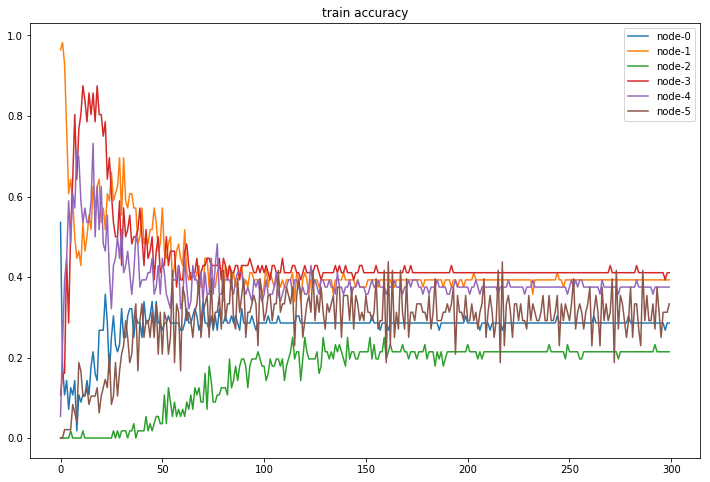

In [5]:
plt.figure(0,(12,8))
plt.title("train accuracy")
for i in range(n_learners):
    plt.plot(train_acc[i], label="node-{}".format(i))
plt.legend()

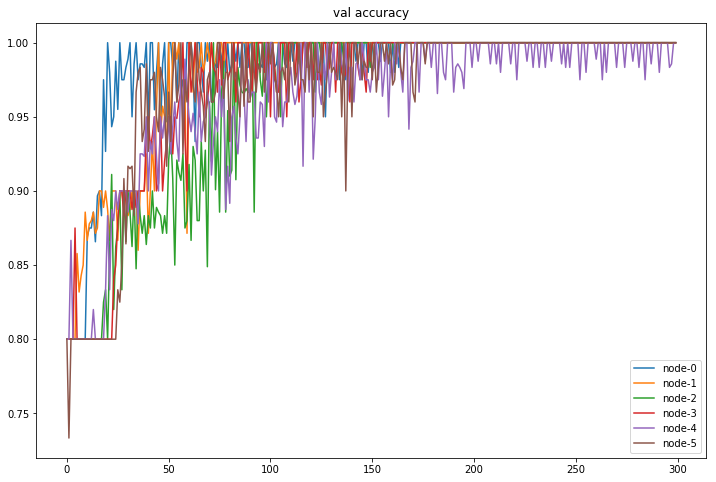

In [6]:
plt.figure(0,(12,8))
plt.title("val accuracy")
for i in range(n_learners):
    plt.plot(val_acc[i], label="node-{}".format(i))
plt.legend()

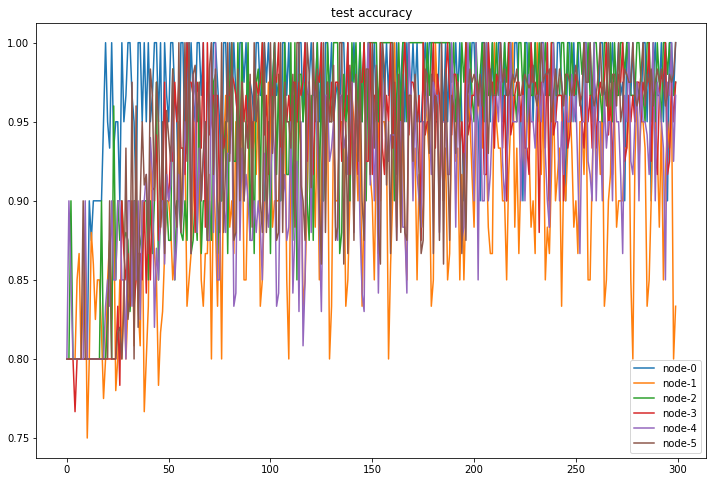

In [7]:
plt.figure(0,(12,8))
plt.title("test accuracy")
for i in range(n_learners):
    plt.plot(test_acc[i], label="node-{}".format(i))
plt.legend()